# Practical 1 - Introduction to Graph Neural Networks with jraph
---

**Tutorial overview:** In this tutorial, you will learn about the various components of Graph Neural Networks and how to implement a Graph Convolutional Network (GCN). We will train and test the GCN on a toy Karate dataset demonstrating how to train and evaluate GNNs on a node classification task.
<br>

**Tutorial outline:**

- Introduction to graphs
- Message propagation
- Graph Convolutional Networks (GCN)
- Node classification using GCNs


## Theory recap




### Fundamental Graph Concepts
A graph consists of a set of nodes and a set of edges, where edges form connections between nodes.

More formally, a graph is defined as $ G = (V, E)$ where $V$ is the set of vertices / nodes, and $E$ is the set of edges.

In an **undirected** graph, each edge is an unordered pair of two nodes $\in V$. E.g. a friend network can be represented as an undirected graph, assuming that the relationship "*A is friends with B*" implies "*B is friends with A*".

In a **directed** graph, each edge is an ordered pair of nodes $\in V$. E.g. a citation network would be best represented with a directed graph, since the relationship "*A cites B*" does not imply "*B cites A*".

The **degree** of a node is defined as the number of edges incident on it, i.e. the sum of incoming and outgoing edges for that node.

The **in-degree** is the sum of incoming edges only, and the **out-degree** is the sum of outgoing edges only.

There are several ways to represent $E$:
1. As a **list of edges**: a list of pairs $(u,v)$, where $(u,v)$ means that there is an edge going from node $u$ to node $v$. <mark>NOTE: in Jraph we are going to use a similar structure!</mark>
2. As an **adjacency matrix**: a binary square matrix $A$ of size $|V| \times |V|$, where $A_{u,v}=1$ iff there is a connection between nodes $u$ and $v$.
3. As an **adjacency list**: An array of $|V|$ unordered lists, where the $i$th list corresponds to the $i$th node, and contains all the nodes directly connected to node $i$.

---

Example: Below is a directed graph with four nodes and five edges.

<center><image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/toy_graph.png" width="400px"></center>

The arrows on the edges indicate the direction of each edge, e.g. there is an edge going from node 0 to node 1. Between node 0 and node 3, there are two edges: one going from node 0 to node 3 and one from node 3 to node 0.

Node 0 has out-degree of 2, since it has two outgoing edges, and an in-degree of 2, since it has two incoming edges.

The list of edges is:
$$[(0, 1), (0, 3), (1, 2), (2, 0), (3, 0)]$$

As adjacency matrix:

$$\begin{array}{l|llll}
 source \setminus dest    & n_0 & n_1 & n_2 & n_3 \\ \hline
n_0 & 0    & 1    & 0    & 1    \\
n_1 & 0    & 0    & 1    & 0    \\
n_2 & 1    & 0    & 0    & 0    \\
n_3 & 1    & 0    & 0    & 0
\end{array}$$

As adjacency list:

$$[\{1, 3\}, \{2\}, \{0\}, \{0\}]$$


### Graph Prediction Tasks
What are the kinds of problems we want to solve on graphs?


The tasks fall into roughly three categories:

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers?
2. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends?
3. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective?

<center><image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px"></center>

*The three main graph learning tasks. Image source: Petar Veličković.*

Which examples of graph prediction tasks come to your mind? Which task types do they correspond to?

We will create and train models on all three task types in this tutorial.

<!--
If applicable, re-iterate on the maths, schematics and high-level ideas that are necessary in the subsequent Practicals. Although we would expect the Lectures to cover the theory in-depth, we should aim to make the tutorials self-contained. However, feel free to add relevant resources as links for further reading for completeness.

This should not be the main focus initially - best to first work on the Practicals and code, and then write the Theory that is needed. -->



### Graph Convolutional Network (GCN) Layer

A GCN aims to emulate the learning process that a traditional convolutional neural network (CNN) does on images. However, differently from images, the structure of graphs is not constrained to a regular grid, and this prevents the use of traditional convolutional filters.

The regularity of grids reflects two properties that are crucial to applying traditional convolutional filters: (i) pixels are ordered, (ii) pixels have fixed-size neighborhoods (each pixel is surrounded by 8 pixels). Because of these properties, the content of images is *invariant* or *equivariant* to translation (shift operation), allowing the shifting of a local convolutional filter (e.g., 3x3) across the different parts of a larger image (e.g., 64x64). Note that a filter performs a weighted sum aggregation over the inputs (pixels) with learnable weights, where each filter input has its own weight.

In graphs, there is no ordering of nodes, and the edges determine the size of each node neighborhood. Hence, we cannot learn a weighted sum of the neighbors as such weights depend on the neighbors' order that is not present. Instead, we need to apply a learnable filter invariant to the neighbors' order. The simplest solution is to apply the same weight to all neighbors without learning the aggregation function. In other words, each neighbor contributes equally. This type of convolutional filter identifies GCNs that are *isotropic*.


<center><image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/cnn_vs_gnn.png" width="400px"></center>

Comparison of CNN and GCN filters.
Image source: https://arxiv.org/pdf/1901.00596.pdf


### Message-Passing
GCNs can be defined using different paradigms. The most widely adopted and easy to understand is *Message-Passing (MP)*. The basic idea of MP is to perform local convolution through two steps:

1. _Compute messages / update node features_: Create a feature vector $\vec{h}_n$ for each node $n$ (e.g. with an MLP). This is going to be the message that this node will pass to neighboring nodes.
2. _Message-passing / aggregate node features_: For each node, calculate a new feature vector $\vec{h}'_n$ based on the messages (features) from the nodes in its neighborhood. In a directed graph, only nodes from incoming edges are counted as neighbors. The image below shows this aggregation step. There are multiple options for aggregation; in *isotropic* GCNs, common aggregations are the mean, the sum, the min, or the max, while in *anisotropic* GCNs, the aggregation depends on variable edge weights (either learned or fixed).

<center><image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_conv.png" width="500px"></center>

*\"A generic overview of a graph convolution operation, highlighting the relevant information for deriving the next-level features for every node in the graph.\"* Image source: Petar Veličković (https://github.com/PetarV-/TikZ)

In the following steps, we will implement the Graph Convolutional Network as introduced by Kipf et al. (2017) in https://arxiv.org/abs/1609.02907, which is one of the basic graph network architectures. We start by building its core building block, the graph convolutional layer.

### Symmetric normalization


Graph nodes may have different numbers of neighbors/degrees, possibly leading to instabilities during neural network training, e.g., exploding or vanishing gradients. To address that, normalization is a commonly used method. In this case, we will normalize by node degrees.

As a first attempt, we could count the number of incoming edges (including self-edge) and divide by that value.

More formally, let $A$ be the adjacency matrix defining the edges of the graph.

Then we define the degree matrix $D$ as a diagonal matrix with $D_{ii} = \sum_jA_{ij}$ (the degree of node $i$)


Now we can normalize $AH$ by dividing it by the node degrees:
$${D}^{-1}AH$$
Note that, with this normalization, we are computing the mean over the neighbors' messages.

Instead, if we want to compute a more dynamic aggregation than the mere mean, we can take into
account both the in and out degrees by computing a *symmetric normalization*, which is also what Kipf and Welling proposed in their [paper](https://arxiv.org/abs/1609.02907):
$$D^{-\frac{1}{2}}AD^{-\frac{1}{2}}H$$


## Implementation


### Setup


In [1]:
!pip install git+https://github.com/deepmind/jraph.git
!pip install flax
!pip install dm-haiku
!pip install networkx
!pip install ogb

  Cloning https://github.com/deepmind/jraph.git to /tmp/pip-req-build-ieeepa9f
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/jraph.git /tmp/pip-req-build-ieeepa9f
  Resolved https://github.com/deepmind/jraph.git to commit 51f5990104f7374492f8f3ea1cbc47feb411c69c
  Preparing metadata (setup.py) ... done
  Created wheel for jraph: filename=jraph-0.0.6.dev0-py3-none-any.whl size=91245 sha256=07b87ea5646061b82559919f219a2cb9c250e61055eab957154fca0c3b5dbbea
  Stored in directory: /tmp/pip-ephem-wheel-cache-b_bv4m3m/wheels/76/61/34/8fb9aa4dac00d471de4a5f7157614181de683c445fc2d640db
Successfully built jraph
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=39a45428d8746f8cfaced8eb153db330b04404f7d749be3898a7fdc3564

In [2]:
# Imports
%matplotlib inline
import functools
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import jraph
import flax
import haiku as hk
import optax
import pickle
import numpy as onp
import networkx as nx
from typing import Any, Callable, Dict, List, Optional, Tuple

---
## Intro to the jraph Library

In the following sections, we will learn how to represent graphs and build GNNs in Python. We will use
[jraph](https://github.com/deepmind/jraph), a lightweight library for working with GNNs in [JAX](https://github.com/google/jax).



#### Representing a graph in jraph

In jraph, a graph is represented with a `GraphsTuple` object. In addition to defining the graph structure of nodes and edges, you can also store node features, edge features and global graph features in a `GraphsTuple`.

In the `GraphsTuple`, edges are represented in two aligned arrays of node indices: senders (source nodes) and receivers (destinaton nodes).
Each index corresponds to one edge, e.g. edge `i` goes from `senders[i]` to `receivers[i]`. This corresponds to concatenating all the $(u, v)$ tuples, and then unzipping them into separete lists (`senders` are all the $u$, `receivers` are all the $v$). Each list will be stored in a JAX array of shape $1 \times |E|$. Note that this way of representing the graph takes advantage of graph **sparsity** (the space required for `senders` and `receivers` is usually significantly lower than the space needed for the full adjacency matrix $|V| \times |V|$).

You can even store multiple graphs in one `GraphsTuple` object.

We will start with creating a simple directed graph with 4 nodes and 5 edges. We will also add toy features to the nodes, using `2*node_index` as the feature.

We will later use this toy graph in the GCN demo.



In [3]:
def build_toy_graph() -> jraph.GraphsTuple:
  """Define a four node graph, each node has a scalar as its feature."""

  # Nodes are defined implicitly by their features.
  # We will add four nodes, each with a feature, e.g.
  # node 0 has feature [0.],
  # node 1 has featre [2.] etc.
  # len(node_features) is the number of nodes.
  node_features = jnp.array([[0.], [2.], [4.], [6.]])

  # We will now specify 5 directed edges connecting the nodes we defined above.
  # We define this with `senders` (source node indices) and `receivers`
  # (destination node indices).
  # For example, to add an edge from node 0 to node 1, we append 0 to senders,
  # and 1 to receivers.
  # We can do the same for all 5 edges:
  # 0 -> 1
  # 1 -> 2
  # 2 -> 0
  # 3 -> 0
  # 0 -> 3
  senders = jnp.array([0, 1, 2, 3, 0])
  receivers = jnp.array([1, 2, 0, 0, 3])

  # You can optionally add edge attributes to the 5 edges.
  edges = jnp.array([[5.], [6.], [7.], [8.], [8.]])

  # We then save the number of nodes and the number of edges.
  # This information is used to make running GNNs over multiple graphs
  # in a GraphsTuple possible.
  n_node = jnp.array([4])
  n_edge = jnp.array([5])

  # Optionally you can add `global` information, such as a graph label.
  global_context = jnp.array([[1]]) # Same feature dims as nodes and edges.
  graph = jraph.GraphsTuple(
      nodes=node_features,
      edges=edges,
      senders=senders,
      receivers=receivers,
      n_node=n_node,
      n_edge=n_edge,
      globals=global_context
      )
  return graph



In [4]:
graph = build_toy_graph()

**Question** How many nodes does our graph have? Do all nodes have features? How many ? What about edges ? Do we graph-level features?

**Answer **
4, yes 1 for each, 1, no, no

#### Visualizing the Graph
To visualize the graph structure of the graph we created above, we will use the [`networkx`](networkx.org) library because it already has functions for drawing graphs.

We first convert the `jraph.GraphsTuple` to a `networkx.DiGraph`.

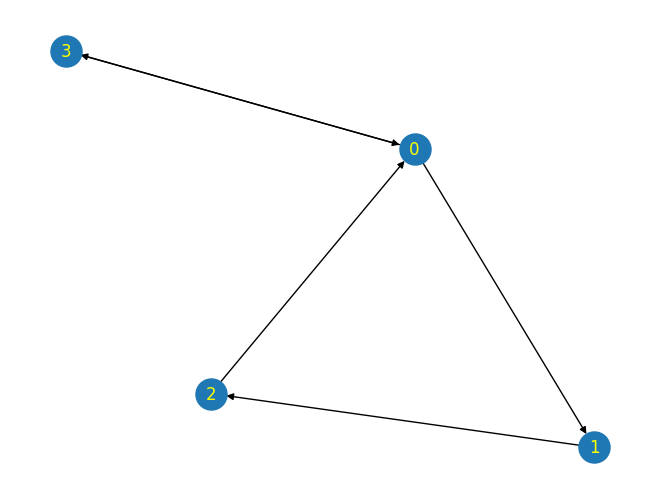

In [5]:
# Utils for visualization
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph

def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

draw_jraph_graph_structure(graph)

**Question: **Why is there only one arrow per edge ? What kind of matrix would have arrows in both sides
**Answer** symmetric

#### Helpers functions: `segment_sum`, `segment_max`
Before starting with the GCN implementation, let's take some time to familiarize with JAX functions that we need for Jraph sparse graph representation. Specifically, we inspect `jax.ops.segment_<fn>` functions, e.g., `segment_sum` and `segment_max`.
These functions allows the application of `<fn>` to chunks (segments) of data present in a single array. They have two arguments, the array on which we want to apply `<fn>`, and a vector of the same size defining the segments; each segment is identified by an integer value.

**SPOILER ALERT** This function is useful for us to to aggregate information for the neighbors of a node! This is an essential step for Message propagation.

See the following examples:

In [6]:
# -- DOCUMENTATION
# Check how `jax.ops.segment_sum` can simplify your life with jraph sparse structures!
# https://jax.readthedocs.io/en/latest/_autosummary/jax.ops.segment_sum.html
# See also TF documentation for a visual illutration:
# https://www.tensorflow.org/api_docs/python/tf/math/segment_sum
data = jnp.arange(5) #  Array([0, 1, 2, 3, 4])
segment_ids = jnp.array([0, 0, 1, 1, 2])
jax.ops.segment_sum(data, segment_ids)

Array([1, 5, 4], dtype=int32)

In [7]:
# -- EXAMPLE: segment_sum

# let's define a simple vector of 10 values
dummy_v = jnp.arange(10)

# now let's create three segments for the array dummy_v
dummy_seg = jnp.array([0,0,0,0,1,1,1,2,2,2])

# now we apply the summation over segments
print(jax.ops.segment_sum(dummy_v, dummy_seg, num_segments=3))

# note that the segments vector does not have to be sorted nor
# the segment positions need to be consecutives
dummy_seg = jnp.array([0,1,1,2,1,1,1,2,2,0])

# now we apply the summation over segments
print(jax.ops.segment_sum(dummy_v, dummy_seg, num_segments=3))

# -- EXAMPLE: segment_max #
logits = jnp.arange(5)
segment_ids = jnp.array([0, 0, 0, 1, 1])
print(jax.ops.segment_max(logits, segment_ids))

[ 6 15 24]
[ 9 18 18]
[2 4]


### Implement a Graph Convolutional Network (GCN)

#### Simple GCN Layer

Now let us implement our first graph convolutional network (GCN)!

In [8]:
def apply_simplified_gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Unpack GraphsTuple
  nodes, _, receivers, senders, _, _, _ = graph

  # 1. Update node features (compute messages)
  # For simplicity, we will first use an identify function here,
  # and replace it with a trainable MLP block later.
  update_node_fn = lambda nodes: nodes
  nodes = update_node_fn(nodes)

  # 2. Aggregate node features over nodes in neighborhood (Message-Passing)
  # Equivalent to jnp.sum(n_node), but jittable
  total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
  aggregate_nodes_fn = jax.ops.segment_sum

  # Compute new node features by aggregating messages from neighboring nodes
  # -- take all nodes sending a message with x[senders],
  # -- and aggregate by receiver with `aggregate_nodes_fn`

  ################
  # Check how `jax.ops.segment_sum` can simplify your life with jraph sparse structures!
  # https://jax.readthedocs.io/en/latest/_autosummary/jax.ops.segment_sum.html
  # See also TF documentation for a visual illutration:
  # https://www.tensorflow.org/api_docs/python/tf/math/segment_sum

  # HINT please take a look at tree.tree_map and fill in the variables
  # nodes = tree.tree_map(lambda x: aggregate_nodes_fn(???, ???, ???), nodes)
  # YOUR CODE HERE
  nodes = tree.tree_map(lambda x: aggregate_nodes_fn(x[senders], receivers,
                                        total_num_nodes), nodes)
  ################

  # Create a new graph with same structure and the updated nodes representation
  out_graph = graph._replace(nodes=nodes)
  return out_graph

In [9]:
graph = build_toy_graph()

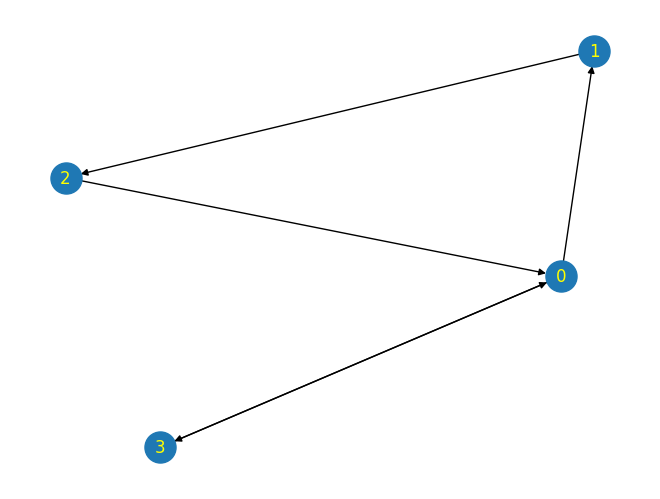

In [10]:
draw_jraph_graph_structure(graph)

In [11]:
out_graph = apply_simplified_gcn(graph)

Since we used the identity function for updating nodes and sum aggregation, we can verify the results pretty easily. As a reminder, in this toy graph, the node features are the same as the node index.

Node 0: sum of features from node 2 and node 3 $\rightarrow$ 10.

Node 1: sum of features from node 0 $\rightarrow$ 0.

Node 2: sum of features from node 1 $\rightarrow$ 2.

Node 3: sum of features from node 0 $\rightarrow$ 0.

In [12]:
out_graph.nodes

Array([[10.],
       [ 0.],
       [ 2.],
       [ 0.]], dtype=float32)

#### Add Trainable Parameters to GCN layer
So far our graph convolution operation doesn't have any learnable parameters.
Let's add an MLP block to the update function to make it trainable.

In [13]:
class MLP(hk.Module):
  def __init__(self, features: jnp.ndarray):
    super().__init__()
    self.features = features

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    layers = []
    for feat in self.features[:-1]:
      layers.append(hk.Linear(feat))
      layers.append(jax.nn.relu)
    layers.append(hk.Linear(self.features[-1]))
    mlp = hk.Sequential(layers)
    return mlp(x)

################
# YOUR CODE HERE
# HINT: instantiate an MLP with dimensions [8,4] and create a function from it
# update_node_fn = lambda x: ???
update_node_fn = lambda x: MLP(features=[8, 4])(x)
################

#### Check outputs of `update_node_fn` with MLP Block

In [14]:
graph = build_toy_graph()

In [15]:
update_node_module = hk.without_apply_rng(hk.transform(update_node_fn))
params = update_node_module.init(jax.random.PRNGKey(42), graph.nodes)
out = update_node_module.apply(params, graph.nodes)

As output, we expect the updated node features. We should see one array of dim 4 for each of the 4 nodes, which is the result of applying a single MLP block to the features of each node individually.

In [16]:
out

Array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.14526582,  0.3303816 , -0.50791126, -0.643716  ],
       [-0.29053164,  0.6607632 , -1.0158225 , -1.287432  ],
       [-0.4357974 ,  0.99114484, -1.5237337 , -1.931148  ]],      dtype=float32)

#### Add Self-Edges (Edges connecting a node to itself)
For each node, add an edge of the node onto itself. This way, nodes will include themselves in the aggregation step.

In [17]:
def add_self_edges_fn(receivers: jnp.ndarray, senders: jnp.ndarray,
                      total_num_nodes: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Adds self edges. Assumes self edges are not in the graph yet."""
  ################
  # YOUR CODE HERE
  # for each node, add a connection to itself, both from the sender and receiver perspective
  # you can easily implement it in a pythonic and vectorized way, by knowing `total_num_nodes`.
  # Hint: Use jnp.concatenate to add indices [0, 1, ... `total_num_nodes-1`] to existing receivers and senders.
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  ################
  return receivers, senders

#### Add Symmetric Normalization

**Implementation tip**:
Keep in mind that we are using sparse matrix operations; thus, we never explicit the adjacency matrix $A$ in its dense form.
We will directly pre-normalize the feature of each node present in each edge by the square root of the in-degrees, and later we will post-normalize by the square root of the out-degrees.

#### General GCN Layer
Now we can write a more general and configurable version of the Graph Convolution layer, allowing the caller to specify:

*   **`update_node_fn`**: Function to use to update node features (e.g. the MLP block version we just implemented)
*   **`aggregate_nodes_fn`**: Aggregation function to use to aggregate messages from neighbourhood.
*  **`add_self_edges`**: Whether to add self edges for aggregation step.
* **`symmetric_normalization`**: Whether to add symmetric normalization.



In [18]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphConvolution(update_node_fn: Callable,
                     aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                     add_self_edges: bool = False,
                     symmetric_normalization: bool = True) -> Callable:
  """Returns a method that applies a Graph Convolution layer.

  Graph Convolutional layer as in https://arxiv.org/abs/1609.02907,
  NOTE: This implementation does not add an activation after aggregation.
  If you are stacking layers, you may want to add an activation between
  each layer.
  Args:
    update_node_fn: function used to update the nodes. In the paper a single
      layer MLP is used.
    aggregate_nodes_fn: function used to aggregates the sender nodes.
    add_self_edges: whether to add self edges to nodes in the graph as in the
      paper definition of GCN. Defaults to False.
    symmetric_normalization: whether to use symmetric normalization. Defaults to
      True.

  Returns:
    A method that applies a Graph Convolution layer.
  """

  def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Convolution layer."""
    nodes, _, receivers, senders, _, _, _ = graph

    ################
    # YOUR CODE HERE
    # Pass the nodes through the `update_node_fn`.
    nodes = update_node_fn(nodes)
    ################

    # Equivalent to jnp.sum(n_node), but jittable
    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    # --

    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      # In principle, a `GraphsTuple` should partition by n_edge, but in
      # this case it is not required since a GCN is agnostic to whether
      # the `GraphsTuple` is a batch of graphs or a single large graph.

      ################
      # YOUR CODE HERE
      # Pass the receiver and sender nodes through `add_self_edges_fn`
      conv_receivers, conv_senders = add_self_edges_fn(receivers, senders,
                                                       total_num_nodes)
      ################
    else:
      ################
      # YOUR CODE HERE
      # Do nothing if no self edges to be added.
      conv_senders = senders
      conv_receivers = receivers
      ################

    # pylint: disable=g-long-lambda
    if symmetric_normalization:
      # Calculate the normalization values.

      # -- Compute in-degree (sender_degree) and out-degree (receiver_degree) of each node
      # -- Remember: The in-degree is the sum of incoming edges only,
      # and the out-degree is the sum of outgoing edges only.

      ################
      # YOUR CODE HERE
      # Tip: all the operations should be jittable!
      # -- take again advantage of `jax.ops.segment_sum`

      # HINT: count_edges_fn = lambda x: jax.ops.segment_sum(
      #    jnp.ones_like(conv_senders), ???, ???)
      count_edges_fn = lambda x: jax.ops.segment_sum(
          jnp.ones_like(conv_senders), x, total_num_nodes)
      ################

      sender_degree = count_edges_fn(conv_senders)
      receiver_degree = count_edges_fn(conv_receivers)

      # 1. Pre normalize by sqrt sender degree:
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      # check https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.rsqrt.html
      nodes = tree.tree_map(
          lambda x: x * jax.lax.rsqrt(jnp.maximum(sender_degree, 1.0))[:, None],
          nodes,
      )

      ################
      # YOUR CODE HERE
      # 2. Aggregate the pre-normalized nodes.
      # HINT: Revist the aggregation function above.
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
      ################

      # 3. Post normalize by sqrt receiver degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x:
          (x * jax.lax.rsqrt(jnp.maximum(receiver_degree, 1.0))[:, None]),
          nodes,
      )

    else:
      # If no normalization is applied, just aggregate

      ################
      # YOUR CODE HERE
      # HINT: Same implementation as the aggregation functon above.
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
      ################

    return graph._replace(nodes=nodes)

  return _ApplyGCN

#### Test General GCN Layer

In [19]:
gcn_layer = GraphConvolution(
    update_node_fn=lambda n: MLP(features=[8, 4])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=True,
    symmetric_normalization=True
)

In [20]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

Array([[-0.29652256,  0.6743886 , -1.0367694 , -1.3139795 ],
       [-0.07263289,  0.16519076, -0.25395557, -0.32185793],
       [-0.21789868,  0.4955723 , -0.76186675, -0.9655737 ],
       [-0.21789865,  0.49557233, -0.7618667 , -0.96557385]],      dtype=float32)

#### Build GCN Model with Multiple Layers
With a single GCN layer, a node's representation after the GCN layer is only
influenced by its direct neighbourhood. However, we may want to consider larger neighbourhoods, i.e. more than just 1 hop away. To achieve that, we can stack
multiple GCN layers, similar to how stacking CNN layers expands the input region.

We will define a network with two GCN layers:

In [21]:
def gcn_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a graph neural network with 3 GCN layers.
  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """

  ################
  # YOUR CODE HERE
  # 1. Build the first GCN layer having a single non-linear projection
  # with dimensionality 8 as update_node_fn.
  # gn = GraphConvolution(update_node_fn=???, add_self_edges=???)
  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
      add_self_edges=True)
  graph = gn(graph)

  # 2. Build the classification head of the model as a GCN layer that project nodes
  # into 2 classes, without applying any non-linearity.
  # gn = GraphConvolution(update_node_fn=???)
  gn = GraphConvolution(
      update_node_fn=hk.Linear(2))
  graph = gn(graph)

  ################
  return graph


In [22]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn_fn))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph

GraphsTuple(nodes=Array([[-1.3036973 , -0.2995631 ],
       [-0.8870537 , -0.2038269 ],
       [-0.30728444, -0.07060772],
       [-0.8870537 , -0.2038269 ]], dtype=float32), edges=Array([[5.],
       [6.],
       [7.],
       [8.],
       [8.]], dtype=float32), receivers=Array([1, 2, 0, 0, 3], dtype=int32), senders=Array([0, 1, 2, 3, 0], dtype=int32), globals=Array([[1]], dtype=int32), n_node=Array([4], dtype=int32), n_edge=Array([5], dtype=int32))

In [23]:
out_graph.nodes

Array([[-1.3036973 , -0.2995631 ],
       [-0.8870537 , -0.2038269 ],
       [-0.30728444, -0.07060772],
       [-0.8870537 , -0.2038269 ]], dtype=float32)

### Node Classification: Train the GCN on a tiny Karate club dataset


#### Zachary's Karate Club Dataset

[Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a small dataset commonly used as an example for a social graph. It's great for demo purposes, as it's easy to visualize and quick to train a model on it.

A node represents a student or instructor in the club. An edge means that those two people have interacted outside of the class. There are two instructors in the club.

Each student is assigned to one of two instructors.

#### Optimizing the GCN on the Karate Club Node Classification Task

The task is to predict the assignment of students to instructors, given the social graph and only knowing the assignment of two nodes (the two instructors) a priori.

In other words, out of the 34 nodes, only two nodes are labeled, and we are trying to optimize the assignment of the other 32 nodes, by **maximizing the log-likelihood of the two known node assignments**.

We will compute the accuracy of our node assignments by comparing to the ground-truth assignments. **Note that the ground-truth for the 32 student nodes is not used in the loss function itself.**

In [24]:
"""Zachary's karate club example.
From https://github.com/deepmind/jraph/blob/master/jraph/examples/zacharys_karate_club.py.
Here we train a graph neural network to process Zachary's karate club.
https://en.wikipedia.org/wiki/Zachary%27s_karate_club
Zachary's karate club is used in the literature as an example of a social graph.
Here we use a graphnet to optimize the assignments of the students in the
karate club to two distinct karate instructors (Mr. Hi and John A).
"""

def get_zacharys_karate_club() -> jraph.GraphsTuple:
  """Returns GraphsTuple representing Zachary's karate club."""
  social_graph = [
      (1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
      (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
      (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
      (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
      (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
      (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
      (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
      (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
      (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
      (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
      (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
      (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
      (33, 31), (33, 32)]
  # Add reverse edges.
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  n_club_members = 34

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))

def get_ground_truth_assignments_for_zacharys_karate_club() -> jnp.ndarray:
  """Returns ground truth assignments for Zachary's karate club."""
  return jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
                    0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [25]:
graph = get_zacharys_karate_club()

In [26]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')

Number of nodes: 34
Number of edges: 156


Visualize the karate club graph with circular node layout:

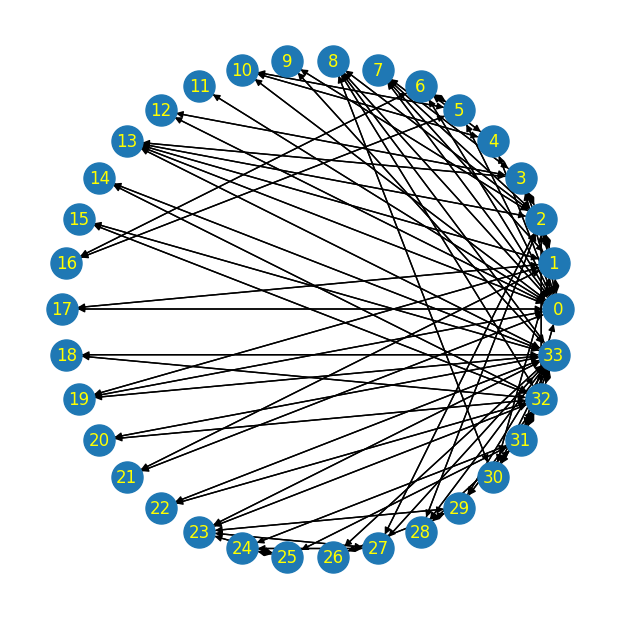

In [27]:
nx_graph = convert_jraph_to_networkx_graph(graph)
pos = nx.circular_layout(nx_graph)
plt.figure(figsize=(6, 6))
nx.draw(nx_graph, pos=pos, with_labels = True, node_size=500, font_color='yellow')

Training and evaluation code:

In [28]:
def optimize_club(network: hk.Transformed, num_steps: int) -> jnp.ndarray:
  """Solves the karate club problem by optimizing the assignments of students."""
  zacharys_karate_club = get_zacharys_karate_club()
  labels = get_ground_truth_assignments_for_zacharys_karate_club()
  params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)

  @jax.jit
  def predict(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, zacharys_karate_club)
    return jnp.argmax(decoded_graph.nodes, axis=1)

  @jax.jit
  def prediction_loss(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, zacharys_karate_club)
    # We interpret the decoded nodes as a pair of logits for each node.
    log_prob = jax.nn.log_softmax(decoded_graph.nodes)
    # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
    # and John A (Node 33).
    return -(log_prob[0, 0] + log_prob[33, 1])

  opt_init, opt_update = optax.adam(1e-2)
  opt_state = opt_init(params)

  @jax.jit
  def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
    """Returns updated params and state."""
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  @jax.jit
  def accuracy(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, zacharys_karate_club)
    return jnp.mean(jnp.argmax(decoded_graph.nodes, axis=1) == labels)

  for step in range(num_steps):
    print(f"step {step} accuracy {accuracy(params).item():.2f}")
    params, opt_state = update(params, opt_state)

  return predict(params)

#### Train the GCN


Let's train the GCN! We expect this model reach an accuracy of about 0.91.

In [29]:
network = hk.without_apply_rng(hk.transform(gcn_fn))
result = optimize_club(network, num_steps=15)

step 0 accuracy 0.06
step 1 accuracy 0.15
step 2 accuracy 0.35
step 3 accuracy 0.50
step 4 accuracy 0.59
step 5 accuracy 0.68
step 6 accuracy 0.71
step 7 accuracy 0.74
step 8 accuracy 0.74
step 9 accuracy 0.76
step 10 accuracy 0.76
step 11 accuracy 0.91
step 12 accuracy 0.91
step 13 accuracy 0.91
step 14 accuracy 0.91


Visualize ground truth and predicted node assignments:

What do you think of the results?

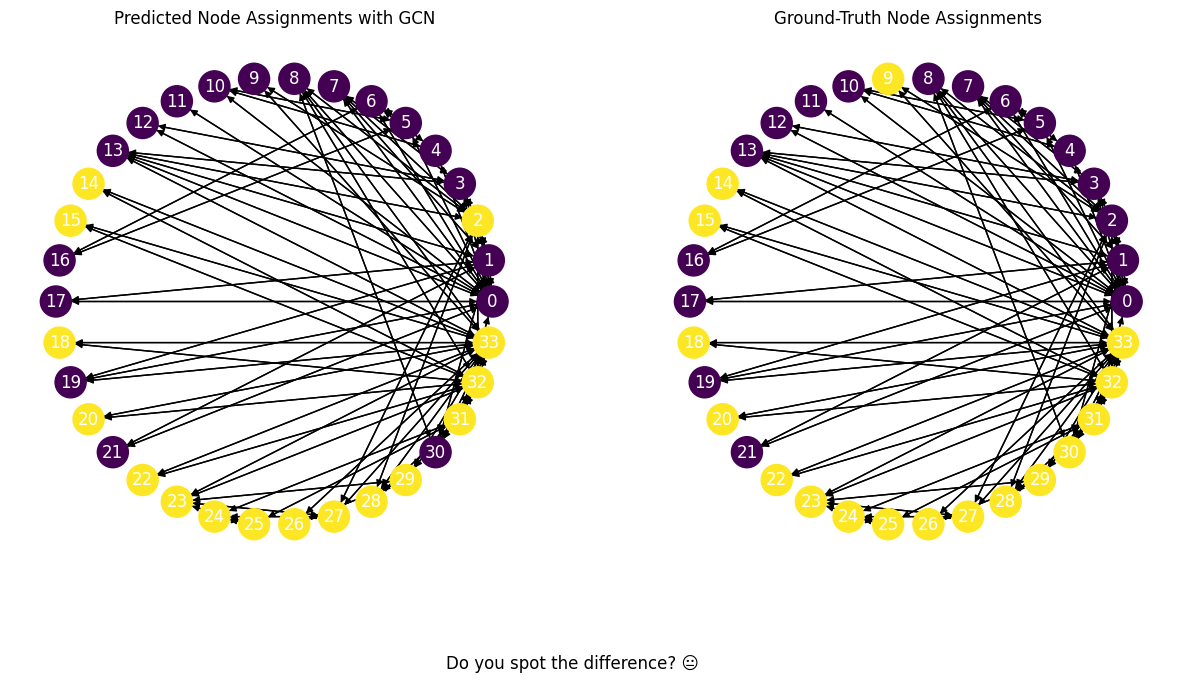

In [30]:
zacharys_karate_club = get_zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result.tolist(),
    font_color='white')
ax1.title.set_text('Predicted Node Assignments with GCN')

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club()
ax2 = fig.add_subplot(122)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white')
ax2.title.set_text('Ground-Truth Node Assignments')
fig.suptitle('Do you spot the difference? 😐', y=-0.01)

plt.show()

#### Analysis

##### How does the network training behave if we omit the effect of normalization? What alternatives do we have?

Many ways:
- other row-normalization $A_{norm} =D^{−1} A$ where contributions sum to 1, limiting extreme gradients
- adaptive normalization where weights of the edges are based on node features i.e.: Attention-based Normalization as we will see in part 2.